In [1]:
# Import 

import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix
import os,datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow.random import set_seed

# by using same seed with your friends, your friends and you will get the same result after computer generated "randomness"
set_seed(42)
np.random.seed(42)

In [2]:
# Define paths for train set and test set 

train_image_dir = 'Dataset/data-science-bowl-2018/train/inputs' # Inputs for training
train_mask_dir = 'Dataset/data-science-bowl-2018/train/masks'   # Masks for training
test_image_dir = 'Dataset/data-science-bowl-2018/test/inputs'   # Inputs for tetsing
test_mask_dir = 'Dataset/data-science-bowl-2018/test/masks'     # Masks for testing

In [3]:
# Create a function for loading the image and loading the mask

def load_image(image_path):
    
    img = tf.io.read_file(image_path) # Read and decode the image (as a tensor)
    img = tf.image.decode_png(img, channels=3)  # For RGB images
    img = tf.image.resize(img, [128, 128])  # Resize images to 128 x 128
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

def load_mask(mask_path):
    
    mask = tf.io.read_file(mask_path)   # Read and decode the mask (assuming mask is grayscale)
    mask = tf.image.decode_png(mask, channels=1)  # Grayscale mask
    mask = tf.image.resize(mask, [128, 128])  # Resize mask to 128 x 128
    mask = mask / 255.0  # Normalize mask values to [0, 1]
    return mask

In [4]:
# Function to load images and masks from directory

def load_dataset(image_dir, mask_dir):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

    images = [load_image(img_path) for img_path in image_paths]
    masks = [load_mask(msk_path) for msk_path in mask_paths]

    return np.array(images), np.array(masks)

In [5]:
# Load training and testing datasets

train_images, train_masks = load_dataset(train_image_dir, train_mask_dir)
test_images, test_masks = load_dataset(test_image_dir, test_mask_dir)

In [6]:
# Augment the images and the labels
# Create a custom augmentation layer through subclassing

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [7]:
# Apply the augmentation, and prepare the train dataset

BATCH_SIZE = 32 
BUFFER_SIZE = 1000

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.cache().shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.batch(32)


.repeat().map(Augment())

.cache()

In [8]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [9]:
# Create a function to visualize the image, label and prediction

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

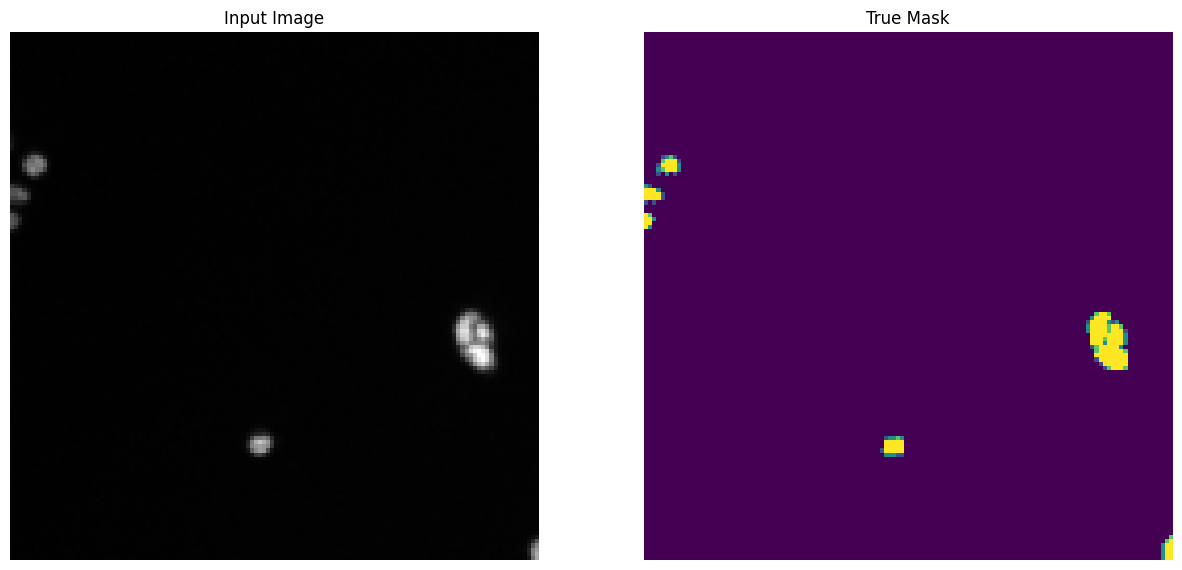

In [10]:
# Visualization the train function 

for images, masks in train_dataset.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [11]:
print(sample_image[0].shape)

print(sample_mask[0].shape)

(128, 3)
(128, 1)


In [26]:
# Model Development

# Get the pretrained model as feature extractor 

base_model = keras.applications.MobileNetV2(input_shape =(128,128,3))   # Setting the Input shape based on size of image and its layers

base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [27]:
# the activation layers as the output of the feature extractor
# Use the activations of these layers

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]    # this layers use to create a Contracting Path or Downsampling Path in U-Net

# Create the feature extractor model that will connect to the upsampling path later

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)    # the Downsampling Path

# Freeze the feature extractor

down_stack.trainable = False

In [28]:
# Create the upsampling layers 

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

# this layers are use to create an Expansive Path or the Upsampling Path in U-Net

In [39]:
# UNET Model

def unet_model(output_channels:int):
    # Use the functional API to build the entire model
    # Start with input

    inputs = keras.layers.Input(shape = [128,128,3])

    # Follow by the feature extractor 
    
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Build the upsampling path by concatenating with the output from feature extractor, along with using the upsampling layers

    for up, skip in zip(up_stack,skips):
        x = up(x)
        concat = keras.layers.Concatenate()

        x = concat([x, skip]) 

    # Construct the last layer, which will be a transpose convulution layer
    
    last = keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2,padding='same') # 64 x 64 ----> 128 x 128
    x = last(x)
 
    model = keras.Model(inputs=inputs, outputs=x)
    return model


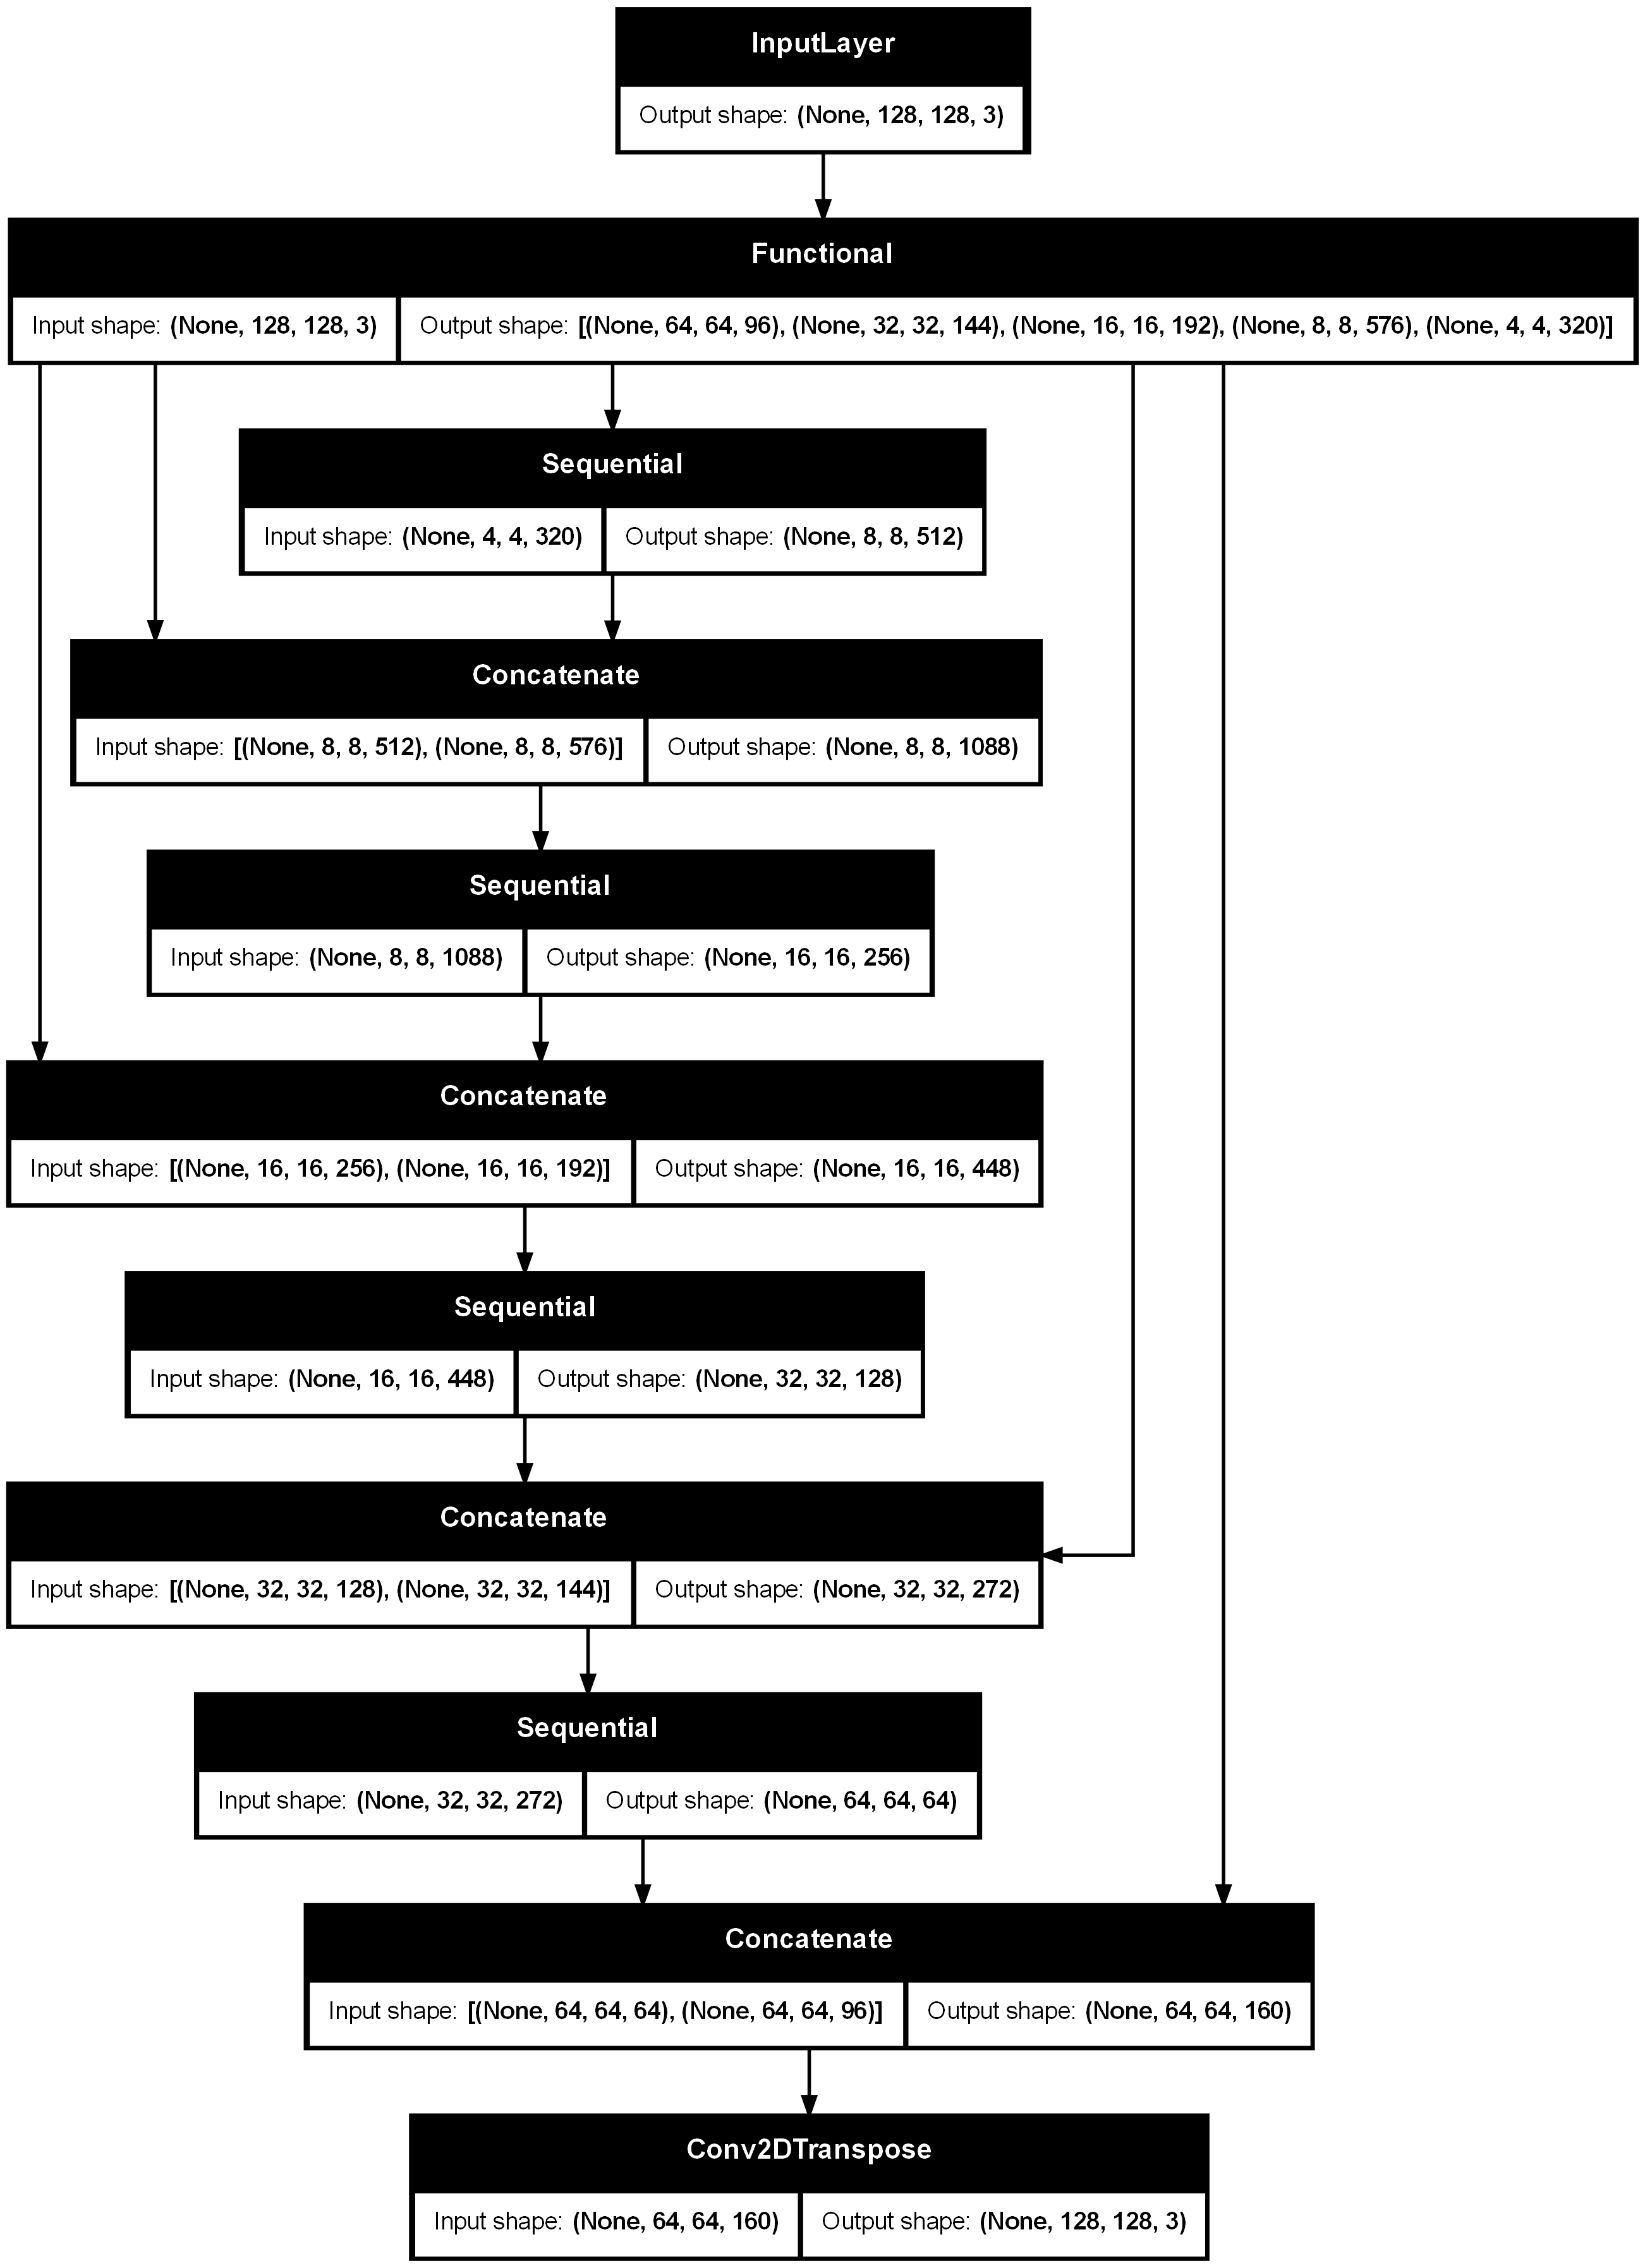

In [40]:
# Use the model U-NET function

model = unet_model(output_channels=3)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy']) # Set the optimizer, loss function and its metric

keras.utils.plot_model(model, show_shapes=True) # Model Architecture

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


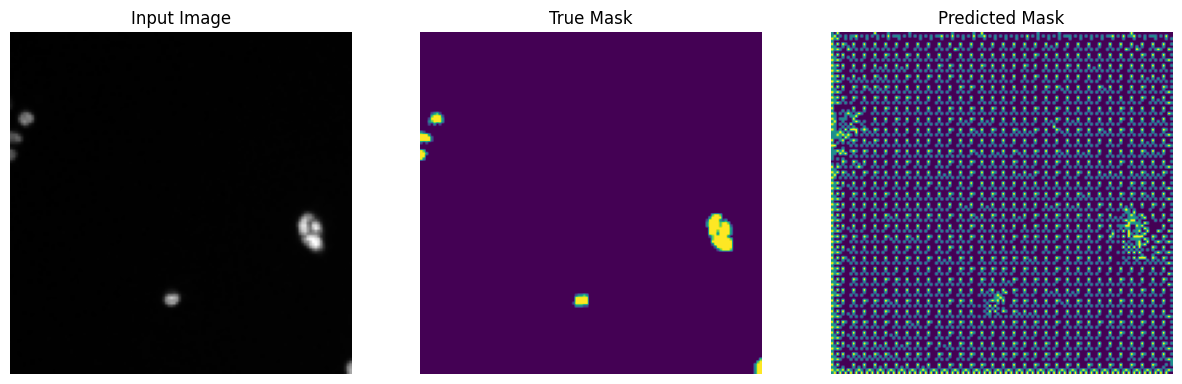

In [41]:
# Create the callback function

def create_mask(pred_mask): # Creating the prediction mask, creating class index for each pixel
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis] # .... same as expand_dims
  return pred_mask[0]


def show_predictions(dataset=None, num=1):  # this create, image, labels
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [42]:
# Create the callbacks

import datetime,os 

logpath = "TensorBoard/Nuclei_Identifier/" + datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)

dc = DisplayCallback()

In [ ]:
# Define Early Stop

es = keras.callbacks.EarlyStopping(patience=3, verbose=3)   # EarlyStopping callback to prevent overfitting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


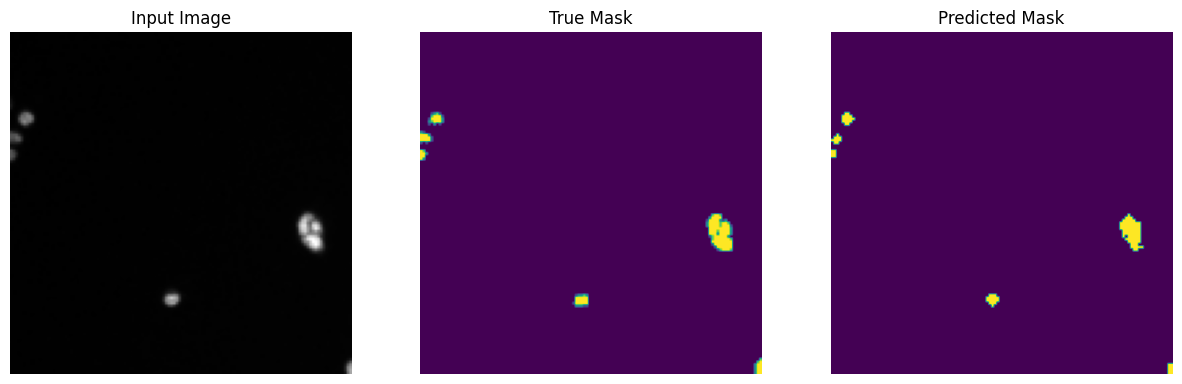


Sample Prediction after epoch 20

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - accuracy: 0.9504 - loss: 0.0766 - val_accuracy: 0.9446 - val_loss: 0.0847
Epoch 20: early stopping


In [44]:
# Model Training 

# Hyperparameter

TRAIN_LENGTH = 603
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 67//BATCH_SIZE//VAL_SUBSPLITS

# Model 
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[tb,dc,es])


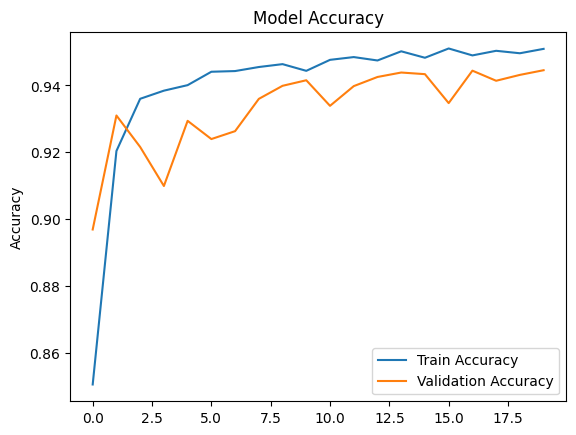

In [45]:
# Plot Accuracy Graph
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.legend()  
plt.show()

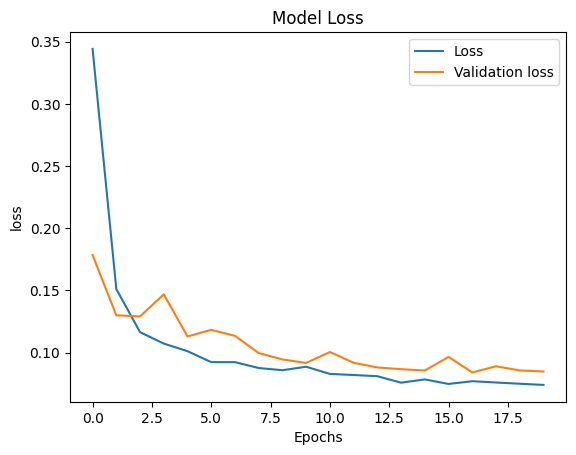

In [46]:
# Plot Loss Graph
plt.plot(model_history.history['loss'], label='Loss')
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


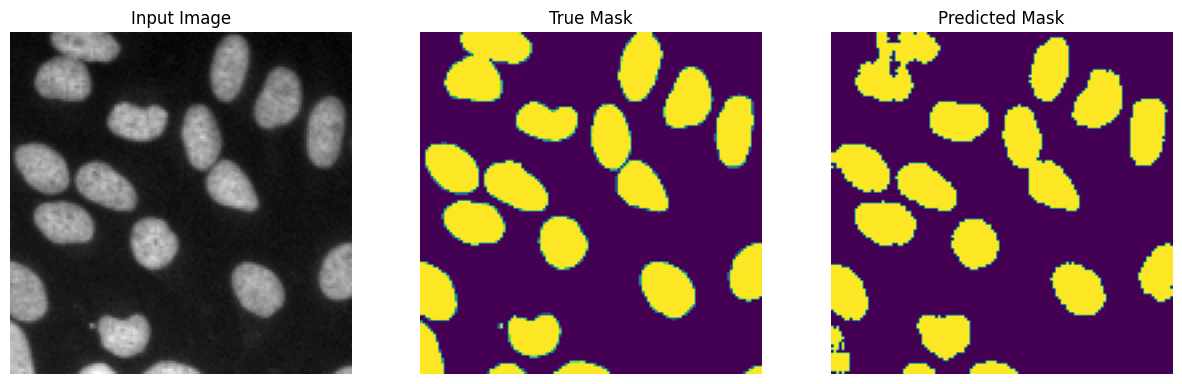

In [47]:
# Use the model to make prediction

for test_img, test_label in test_dataset.take(1):
    predictions = model.predict(test_img)
    predictions = tf.math.argmax(predictions, axis=-1)
    predictions = tf.expand_dims(predictions, axis=-1)


display([test_img[9],test_label[9],predictions[9]])

In [49]:
# To the save Model

import pickle

Model_path = os.path.join(os.getcwd(),'Model','nuclei_identifier.h5')
with open (Model_path,"wb") as file:
    pickle.dump('nuclei_identifier.h5',file)